<a href="https://colab.research.google.com/github/ammobam/Display_SensorData/blob/main/210810_%EB%B6%84%EB%A5%98_%EB%AA%A8%EB%8D%B8%EB%A7%81_%EB%B0%8F_%ED%8F%89%EA%B0%80%EC%A7%80%ED%91%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

## 데이터 불러오기
* 결측치처리 완료
* 상관계수 0.9 이상인 컬럼 삭제 완료
* VIF 값이 30 이하가 될 때까지 컬럼 삭제 완료
    * 삭제 방법 : VIF 연산 > 가장 높은 VIF값이 30 이상이면 그 컬럼 삭제 > VIF 연산 반복
* 할 일
    * right 컬럼 지우기
    * 스케일링
    * PCA 수행
    * 나온 2개 값으로 산포도 그려보기
    * 설명변수 비율 뽑아서 가장 큰 피처들 2개로 산포도 그려서 비교해볼까?

In [14]:
# 데이터 불러오기 - VIF 값이 30 이하가 될때가지 컬럼을 삭제하며 반복 수행한 결과 (179개 컬럼)
#import pandas as pd
origin_data = pd.read_csv('/content/drive/MyDrive/나무플래닛/1. 데이터_디스플레이/factory_glass_2016.zip', encoding='cp949')
origin_data = origin_data.set_index('dat...date.name.', drop=True)

print(len(origin_data.columns))
origin_data.columns
origin_data.head()
# 레이블 : 'L.RD', 'L.Vac', 'R.RD', 'R.Vac'

840


,LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101,LIFT.OUT.ROL.MTR.M2.SPD.1WSI40102,LIFT.OUT.ROL.MTR.M3.SPD.1WSI40103,LEHR.DRV.MTR..M4.1.SPD.1WSI40104,LEHR.DRV.MTR..M4.2.SPD.1WSI40105,LEHR.DRV.MTR..M5.1.SPD.1WSI40106,LEHR.DRV.MTR..M5.2.SPD.1WSI40107,LEHR.DRV.MTR..M6.1.SPD.1WSI40108,LEHR.DRV.MTR..M6.2.SPD.1WSI40109,LEHR.DRV.MTR..M7.1.SPD.1WSI40110,LEHR.DRV.MTR..M7.2.SPD.1WSI40111,LEHR.DRV.MTR..M8.1.SPD.1WSI40112,LEHR.DRV.MTR..M8.2.SPD.1WSI40113,LEHR.DRV.MTR..M9.1.SPD.1WSI40114,LEHR.DRV.MTR..M9.2.SPD.1WSI40115,DRIVE.MOTOR.M10.1.SPEED.1WSI40116,LEHR.DRV.MTR..M10.2.SPD.1WSI40117,LEHR.DRV.MTR..M11.1.SPD.1WSI40118,DRIVE.MOTOR.M11.2.SPEED.1WSI40119,LEHR.DRV.MTR..M12.1.SPD.1WSI40120,LEHR.DRV.MTR..M12.2.SPD.1WSI40121,LEHR.DRV.MTR..M13.1.SPD.1WSI40122,LEHR.DRV.MTR..M13.2.SPD.1WSI40123,LEHR.DRV.MTR..M14.1.SPD.1WSI40124,LEHR.DRV.MTR..M14.2.SPD.1WSI40125,LEHR.DRV.MTR..M15.1.SPD.1WSI40126,LEHR.DRV.MTR..M15.2.SPD.1WSI40127,LEHR.DRV.MTR..M16.1.SPD.1WSI40128,DRIVE.MOTOR.M16.2.SPEED.1WSI40129,LEHR.DRV.MTR..M17.1.SPD.1WSI40130,LEHR.DRV.MTR..M17.2.SPD.1WSI40131,LEHR.DRV.MTR..M18.1.SPD.1WSI40132,LEHR.DRV.MTR..M18.2.SPD.1WSI40133,DRIVE.MOTOR.M19.1.SPEED.1WSI40134,LEHR.DRV.MTR..M19.2.SPD.1WSI40135,X1WOS45101_PV,X1WOS45102_PV,X1WOS45103_PV,X1WOS45104_PV,X1WOS45105_PV,...,S_C1_C2_L_L,S_C1_C2_L_R,S_C2_C3_U_L,S_C2_C3_U_R,S_C2_C3_L_L,S_C2_C3_L_R,S_C3_C4_U_L,S_C3_C4_U_R,S_C3_C4_L_L,S_C3_C4_L_R,S_AB1_AB11_L,S_AB1_AB11_R,S_AB11_AB7_L,S_AB11_AB7_R,S_AB7_C4_L,S_AB7_C4_R,S_C4_RET_L,S_C4_RET_R,S_RET_F_L,S_RET_F_R,STD_U_L,STD_U_R,STD_L_L,STD_L_R,STD_GLS_L,STD_GLS_R,투입.LEFT.,투입.RIGHT.,ROLLDOWN.폐기.LEFT.,진공패드.폐기.LEFT.,ROLLDOWN.폐기.RIGHT.,진공패드.폐기.RIGHT.,폐기율...,ROLLDOWN.진공패드.폐기율..LEFT.,ROLLDOWN.진공패드.폐기율..RIGHT.,ROLLDOWN.진공패드.폐기율..전체.,L.RD,L.Vac,R.RD,R.Vac
dat...date.name.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 07,-1.772682,-1.713219,-1.734851,-1.590051,-1.636293,-1.575213,-1.636293,-1.548119,-1.824581,-1.548119,-1.8189,-1.548119,-1.779407,-1.548119,-1.779407,-1.548119,-1.806012,-1.548119,-1.775051,-1.548119,-1.776634,-1.548119,-1.766604,-1.548119,-1.775051,-1.638207,-1.728206,-1.674911,-1.641818,-1.662151,-1.636293,-1.622314,-1.653428,-1.548119,-1.807954,-1.73,-1.315444,-1.620631,-1.517655,-1.804912,...,-0.195736,0.706941,1.477203,0.410847,0.491620,0.942180,2.776941,2.492437,2.060406,2.612283,1.726404,1.461145,-1.192642,-1.134471,2.599429,2.690433,-0.365598,-0.659319,-1.963403,-1.621407,0.523950,1.951349,2.248106,2.767676,3.012706,3.069007,80,74,2,5,8,3,11.69,8.75,14.86,11.69,0.025,0.063,0.108,0.041
2016-01-01 08,-1.772682,-1.713219,-1.734851,-1.590051,-1.636293,-1.575213,-1.636293,-1.548119,-1.824581,-1.548119,-1.8189,-1.548119,-1.779407,-1.548119,-1.779407,-1.548119,-1.806012,-1.548119,-1.775051,-1.548119,-1.776634,-1.548119,-1.766604,-1.548119,-1.775051,-1.638207,-1.728206,-1.674911,-1.641818,-1.662151,-1.636293,-1.622314,-1.653428,-1.548119,-1.807954,-1.73,-1.315444,-1.620631,-1.517655,-1.804912,...,-0.500742,0.822657,1.495204,0.397591,0.587871,0.938186,2.888919,2.573187,2.161149,2.664726,1.682081,1.414518,-1.109125,-1.042269,2.588703,2.654307,-0.348979,-0.560103,-1.978936,-1.810022,0.566521,2.010125,2.364418,2.842630,3.022998,3.069274,92,75,0,2,10,0,7.19,2.17,13.33,7.19,0.000,0.022,0.133,0.000
2016-01-01 09,-1.772682,-1.713219,-1.734851,-1.590051,-1.636293,-1.575213,-1.636293,-1.548119,-1.824581,-1.548119,-1.8189,-1.548119,-1.779407,-1.548119,-1.779407,-1.548119,-1.806012,-1.548119,-1.775051,-1.548119,-1.776634,-1.548119,-1.766604,-1.548119,-1.775051,-1.638207,-1.728206,-1.674911,-1.641818,-1.662151,-1.636293,-1.622314,-1.653428,-1.548119,-1.807954,-1.73,-1.315444,-1.620631,-1.517655,-1.804912,...,-0.164556,0.962210,1.552127,0.460702,0.397216,0.843443,2.868644,2.486441,2.183298,2.638130,1.632955,1.359022,-0.986580,-0.928583,2.550175,2.606185,-0.456071,-0.644073,-1.878611,-1.742395,0.545936,2.002820,2.397034,2.817728,2.936967,2.969952,64,66,1,4,0,0,3.85,7.81,0.00,3.85,0.016,0.063,0.000,0.000
2016-01-01 10,-1.772682,-1.713219,-

In [15]:
# 데이터 불러오기 - VIF 값이 30 이하가 될때가지 컬럼을 삭제하며 반복 수행한 결과 (179개 컬럼)
#import pandas as pd
fact_data = pd.read_csv('/content/drive/MyDrive/나무플래닛/3. 산출물/0804 VIF 수행후 컬럼삭제_Right 컬럼 포함됨/fact_data_vif.csv')
fact_data = fact_data.set_index('dat...date.name.', drop=True)

print(len(fact_data.columns))
fact_data.columns

179


Index(['X1WOS45106_PV', 'X1WOS45107_PV', 'X1WOS45109_PV',
       'DCS_Offset_RPM_M11.1WOS45111_PV', 'DCS_Offset_RPM_M15.1WOS45115_PV',
       'DB.N2.SCREEN.FLOW.LEFT.1FI49011_PV', 'N2.TO.EA1313A.1FI33503A_PV',
       'ROOF.HEATING.Zone.1.1JIC31101.PV', 'ROOF.HEATING.Zone.2.1JIC31102.PV',
       'ROOF.HEATING.Zone.3.1JIC31103.PV',
       ...
       'S_C1_C2_L_L', 'S_C2_C3_U_R', 'S_C3_C4_U_L', '투입.LEFT.',
       'ROLLDOWN.폐기.LEFT.', '진공패드.폐기.LEFT.', 'ROLLDOWN.폐기.RIGHT.',
       '진공패드.폐기.RIGHT.', 'ROLLDOWN.진공패드.폐기율..LEFT.',
       'ROLLDOWN.진공패드.폐기율..RIGHT.'],
      dtype='object', length=179)

## PCA 수행하기 전 데이터 전처리

### Right 공정 컬럼 제외

In [16]:
# 컬럼명 분류 딕셔너리 파일 불러오기
import pickle

# load data
with open('/content/drive/MyDrive/나무플래닛/3. 산출물/dict_left_right.pickle', 'rb') as fr:
    dict_l_r = pickle.load(fr)

In [17]:
# Right 공정 컬럼명만 리스트로 만들기
print(dict_l_r.keys())
print(type(dict_l_r['Right']))
col_right = dict_l_r['Right']

dict_keys(['Left', 'Right', 'Center'])
<class 'list'>


In [18]:
# 전체 컬럼에서 right 공정 컬럼을 제외한 컬럼명 리스트 만들기

col_use = []

# 데이터의 전체 컬럼에 대해서
for col in fact_data.columns:
    # 만약 컬럼이 right 생산공정에 포함되지 않는다면
    if col not in col_right:
        # 그 컬럼을 col_use 리스트에 추가할 것
        col_use.append(col)

print(len(col_use))
# 179 -> 150개로 줄어들음

150


In [19]:
# 데이터프레임 저장
fact_data_150 = fact_data[col_use]
# 확인
fact_data_150.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8145 entries, 2016-01-01 07 to 2016-12-31 23
Columns: 150 entries, X1WOS45106_PV to ROLLDOWN.진공패드.폐기율..LEFT.
dtypes: float64(150)
memory usage: 9.4+ MB


In [20]:
# 레이블 컬럼이 쓸 컬럼목록에 있는지 확인
col_label = ['L.RD', 'L.Vac', 'R.RD', 'R.Vac']
for col in col_label:
    if col in col_use:
        print("확인", col)
# 없음

### 컬럼 확인

In [21]:
# 모든 행에 대해 같은 값을 갖는 컬럼이 있는지 확인
all_value_same_col=[]
for i in range(len(fact_data_150.columns)):
    if min(fact_data_150.iloc[:, i]) == max(fact_data_150.iloc[:, i]):
        print(i)
        all_value_same_col.append(i)
if len(all_value_same_col)==0:
    print("모든 행에 대해 같은 값을 갖는 컬럼은 없습니다")

모든 행에 대해 같은 값을 갖는 컬럼은 없습니다


In [22]:
fact_data_150.describe()

,X1WOS45106_PV,X1WOS45107_PV,X1WOS45109_PV,DCS_Offset_RPM_M11.1WOS45111_PV,DCS_Offset_RPM_M15.1WOS45115_PV,DB.N2.SCREEN.FLOW.LEFT.1FI49011_PV,N2.TO.EA1313A.1FI33503A_PV,ROOF.HEATING.Zone.1.1JIC31101.PV,ROOF.HEATING.Zone.2.1JIC31102.PV,ROOF.HEATING.Zone.3.1JIC31103.PV,ROOF.HEATING.Zone.4.1JIC31104.PV,ATM.FLOW.SECT.9.N2.1FIC33415.PV,Gross.width,Left.edge,LOWER.AB7.Z92.TMP.1TIC41751.PV,UPPER.C2..Z175.TMP.1TIC42307.PV,LIFT.OUT.ROL.MTR.M1.CUR.1WII40101.PV,LIFT.OUT.ROL.MTR.M2.CUR.1WII40102.PV,LEHR.DRV.MTR..M4.1.CUR.1WII40104.PV,LEHR.DRV.MTR..M6.1.CUR.1WII40108.PV,LEHR.DRV.MTR..M7.1.CUR.1WII40110.PV,LEHR.DRV.MTR..M7.2.CUR.1WII40111.PV,LEHR.DRV.MTR..M8.1.CUR.1WII40112.PV,LEHR.DRV.MTR..M8.2.CUR.1WII40113.PV,LEHR.DRV.MTR..M10.2.CUR.1WII40117.PV,LEHR.DRV.MTR..M11.1.CUR.1WII40118.PV,LEHR.DRV.MTR..M12.1.CUR.1WII40120.PV,LEHR.DRV.MTR..M13.1.CUR.1WII40122.PV,LEHR.DRV.MTR..M15.1.CUR.1WII40126.PV,LEHR.DRV.MTR..M16.1.CUR.1WII40128.PV,LEHR.DRV.MTR..M16.2.CUR.1WII40129.PV,LEHR.DRV.MTR..M17.1.CUR.1WII40130.PV,LEHR.DRV.MTR..M18.1.CUR.1WII40132.PV,LEHR.DRV.MTR..M18.2.CUR.1WII40133.PV,LEHR.DRV.MTR..M19.1.CUR.1WII40134.PV,X1WOS45102_PV.1,X1WOS45106_PV.1,DCS_Offset_RPM_M11.1WOS45111_PV.1,DCS_Offset_RPM_M14.1WOS45114_PV.1,TMP.TIN..BAY.1.LEFT.1TI30201.PV,...,bay6_7,l_r_tin_bay10,lc_rc_btm_dn,c_btm_up_dn,l_r_top_n.1,top_1,top_5,D_AB1_L_LR,D_AB2_L_LR,D_AB3_L_LR,D_AB4_U_LR,D_AB5_U_LR,D_AB9_L_LR,D_AB10_U_LR,D_AB11_U_LR,D_AB11_L_LR,D_AB7_L_UL,D_AB8_L_UL,D_C1_U_LR,D_C3_U_LR,D_C4_U_LR,D_C4_L_LR,D_C2_L_UL,D_GLS_AB11_LR,D_GLS_AB7_LR,D_GLS_F_LR,D_GLS_RET_LR,S_AB1_AB2_U_L,S_AB2_AB3_U_L,S_AB4_AB5_U_L,S_AB6_AB7_L_L,S_AB8_AB9_U_L,S_AB9_AB10_U_L,S_AB10_AB11_L_L,S_C1_C2_L_L,S_C3_C4_U_L,투입.LEFT.,ROLLDOWN.폐기.LEFT.,진공패드.폐기.LEFT.,ROLLDOWN.진공패드.폐기율..LEFT.
count,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,...,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000
mean,-0.000109,-0.000066,-0.000066,-0.000126,0.000195,-0.000921,-0.001064,-0.000745,-0.001166,0.000506,-0.000164,-0.002465,0.000362,0.000672,0.000096,0.000519,-0.000462,-0.000374,0.000010,-0.000065,-0.000015,0.000020,-0.002179,0.000004,-0.000196,0.000248,0.000088,0.000015,-0.000738,-0.000007,-0.000013,-0.000010,0.000115,-0.000010,0.000586,-0.001312,0.000114,-0.000012,0.000059,0.000470,...,-0.000104,0.001108,0.001127,0.000704,0.000652,-0.000388,0.001061,-0.000284,0.000130,0.000162,0.000249,0.000042,-0.000222,0.000974,0.001102,0.001712,-0.000169,-0.000120,-0.000605,0.000553,0.000667,0.000614,-0.000795,0.000196,0.001651,0.000196,0.001021,-0.000788,-0.000435,0.000490,0.000043,0.000203,0.000325,-0.000536,-0.000530,0.000242,93.602210,1.562799,1.754451,3.720192
std,1.000423,1.000427,1.000427,1.000420,1.000407,0.999936,0.999770,1.000106,0.999638,1.000281,1.000414,0.996887,1.000346,1.000141,1.000423,1.000272,1.000305,1.000348,1.000430,1.000427,1.000430,1.000429,0.996634,1.000430,1.000407,1.000394,1.000425,1.000430,1.000113,1.000430,1.000430,1.000430,1.000422,1.000430,1.000229,0.999675,1.000360,1.000368,1.000366,1.000301,...,1.000423,0.999713,0.999690,1.000140,1.000182,1.000266,0.999774,1.000382,1.000420,1.000414,1.000393,1.000427,1.000400,0.999875,0.999720,0.998717,1.000411,1.00042

In [23]:
fact_data_150.iloc[:, 1].describe()

count    8145.000000
mean       -0.000066
std         1.000427
min       -12.992791
25%         0.076956
50%         0.076956
75%         0.076956
max         0.076956
Name: X1WOS45107_PV, dtype: float64

### 아무리봐도 피처는 아닌 것 같은 컬럼 제거하기

In [24]:
# 아무리봐도 피처는 아닌 것 같은 컬럼 제거하기
#print(fact_data_151_LRD.columns)
col_susang = ['투입.LEFT.', 'ROLLDOWN.폐기.LEFT.', '진공패드.폐기.LEFT.','ROLLDOWN.진공패드.폐기율..LEFT.']
col_use = []
for col in fact_data_150.columns:
    if col not in col_susang:
       col_use.append(col)
print(len(col_use)) # 146개

# 데이터프레임 만들기
fact_data_146 = fact_data[col_use]
# 결측치 없는 것 확인
print("결측치 개수", fact_data_146.isnull().sum().sum())
# 확인
fact_data_146.head()

146
결측치 개수 0


,X1WOS45106_PV,X1WOS45107_PV,X1WOS45109_PV,DCS_Offset_RPM_M11.1WOS45111_PV,DCS_Offset_RPM_M15.1WOS45115_PV,DB.N2.SCREEN.FLOW.LEFT.1FI49011_PV,N2.TO.EA1313A.1FI33503A_PV,ROOF.HEATING.Zone.1.1JIC31101.PV,ROOF.HEATING.Zone.2.1JIC31102.PV,ROOF.HEATING.Zone.3.1JIC31103.PV,ROOF.HEATING.Zone.4.1JIC31104.PV,ATM.FLOW.SECT.9.N2.1FIC33415.PV,Gross.width,Left.edge,LOWER.AB7.Z92.TMP.1TIC41751.PV,UPPER.C2..Z175.TMP.1TIC42307.PV,LIFT.OUT.ROL.MTR.M1.CUR.1WII40101.PV,LIFT.OUT.ROL.MTR.M2.CUR.1WII40102.PV,LEHR.DRV.MTR..M4.1.CUR.1WII40104.PV,LEHR.DRV.MTR..M6.1.CUR.1WII40108.PV,LEHR.DRV.MTR..M7.1.CUR.1WII40110.PV,LEHR.DRV.MTR..M7.2.CUR.1WII40111.PV,LEHR.DRV.MTR..M8.1.CUR.1WII40112.PV,LEHR.DRV.MTR..M8.2.CUR.1WII40113.PV,LEHR.DRV.MTR..M10.2.CUR.1WII40117.PV,LEHR.DRV.MTR..M11.1.CUR.1WII40118.PV,LEHR.DRV.MTR..M12.1.CUR.1WII40120.PV,LEHR.DRV.MTR..M13.1.CUR.1WII40122.PV,LEHR.DRV.MTR..M15.1.CUR.1WII40126.PV,LEHR.DRV.MTR..M16.1.CUR.1WII40128.PV,LEHR.DRV.MTR..M16.2.CUR.1WII40129.PV,LEHR.DRV.MTR..M17.1.CUR.1WII40130.PV,LEHR.DRV.MTR..M18.1.CUR.1WII40132.PV,LEHR.DRV.MTR..M18.2.CUR.1WII40133.PV,LEHR.DRV.MTR..M19.1.CUR.1WII40134.PV,X1WOS45102_PV.1,X1WOS45106_PV.1,DCS_Offset_RPM_M11.1WOS45111_PV.1,DCS_Offset_RPM_M14.1WOS45114_PV.1,TMP.TIN..BAY.1.LEFT.1TI30201.PV,...,LOR.2.L.Hori,LOR.3.L.Axis,LOR.3.L.Hori,bay2_4,bay6_7,l_r_tin_bay10,lc_rc_btm_dn,c_btm_up_dn,l_r_top_n.1,top_1,top_5,D_AB1_L_LR,D_AB2_L_LR,D_AB3_L_LR,D_AB4_U_LR,D_AB5_U_LR,D_AB9_L_LR,D_AB10_U_LR,D_AB11_U_LR,D_AB11_L_LR,D_AB7_L_UL,D_AB8_L_UL,D_C1_U_LR,D_C3_U_LR,D_C4_U_LR,D_C4_L_LR,D_C2_L_UL,D_GLS_AB11_LR,D_GLS_AB7_LR,D_GLS_F_LR,D_GLS_RET_LR,S_AB1_AB2_U_L,S_AB2_AB3_U_L,S_AB4_AB5_U_L,S_AB6_AB7_L_L,S_AB8_AB9_U_L,S_AB9_AB10_U_L,S_AB10_AB11_L_L,S_C1_C2_L_L,S_C3_C4_U_L
dat...date.name.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 07,0.126294,0.076956,0.076956,0.147152,-0.227141,-1.514135,-0.218748,0.048973,-3.87936,-2.296037,0.191359,-0.022694,3.027949,2.433864,1.290385,-1.994935,2.803512,2.180684,-0.011076,0.07524,0.01758,-0.02383,5.289937,-0.237516,-4.384738,-0.171091,-0.102056,-0.017896,0.858553,0.008717,0.015664,0.011076,-0.133738,0.011076,1.531614,-0.911596,5.486833,5.271747,6.241618,0.054335,...,0.754759,0.367484,2.324515,1.386470,3.258018,0.069853,3.293793,0.843899,1.900728,2.707067,1.237408,0.143199,-0.264129,-1.785276,-0.464619,-0.866448,0.133905,1.183474,0.671758,2.048795,-0.414553,2.262545,1.014661,1.935018,0.878525,1.400976,1.264824,-0.331785,-0.336811,0.392527,-1.204339,0.022728,-1.047496,0.040088,-2.477830,1.012915,-0.398517,-1.277785,-0.195736,2.776941
2016-01-01 08,0.126294,0.076956,0.076956,0.147152,-0.227141,-1.514135,-0.218748,0.048973,-3.87936,-2.296037,0.191359,-0.022694,3.053693,2.392478,1.189370,-2.011604,2.808048,1.598043,-0.011076,0.07524,0.01758,-0.02383,4.508077,-0.237516,-4.384738,-0.171091,-0.102056,-0.017896,0.858553,0.008717,0.015664,0.011076,-0.133738,0.011076,1.531614,-1.570853,-0.098112,0.015846,-0.080082,0.049592,...,0.079794,-0.050686,0.857440,1.417538,3.257741,0.102734,3.272101,0.882758,1.920147,2.753289,1.315761,0.164009,-0.229654,-1.734957,-0.426076,-0.885489,0.134373,1.194699,0.569452,2.015731,-0.302930,2.162538,0.978115,1.945713,0.765455,1.269891,1.253210,-0.201602,-0.023749,0.643118,-0.700142,-0.021609,-1.063102,0.030658,-2.508000,1.043599,-0.367705,-1.201661,-0.500742,2.888919
2016-01-01 09,0.126294,0.076956,0.076956,0.147152,-0.227141,-1.514135,-0.218748,0.048973,-3.87936,-2.296037,0.191359,-0.022694,3.079437,2.433864,1.041403,-2.104412,1.921064,1.598020,-0.011076,0.07524,0.01758,-0.02383,5.371871,-0.237516,-4.384738,-0.171091,-0.102056,-0.017896,0.858553,0.008717,0.015664,0.011076,2.421443,0.011076,1.531614,-1.570853,-0.098112,0.015846,-0.080082,0.062471,...,-0.328752,-0.410132,-0.717783,1.443347,3.259706,0.119169,3.211826,0.986665,1.717819,2.992712,1.790774,0.172756,-0.199157,-1.786606,-0.391402,-0.872139,0.247968,1.275461,0.585925,2.181967,-0.312238,2.205827,1.060357,1.989144,0.648465,1.058985,1.517443,-0.001965,0.2

### 스케일링 하기 전에 값의 범위 확인

In [25]:
# 모든 행에 대해 0~1 사이의 값을 넘는 컬럼이 있는지 확인
scale_needcol = []

# 전체 컬럼에 대해서
for i in range(len(fact_data_146.columns)):
    # 각 컬럼의 최소값
    min_value = min(fact_data_146.iloc[:, i])
    # 각 컬럼의 최대값
    max_value = max(fact_data_146.iloc[:, i])
    # 최소값이 0보다 작거나, 최대값이 1보다 큰 경우는 스케일링이 필요한 컬럼임
    if min_value<0 or max_value>1:
        scale_needcol.append(i)

# 스케일링이 필요한 컬럼 수 확인
print(len(scale_needcol))
## 스케일링이 필요함

146


## 데이터 레이블을 이용하여 불량품/양품 구분하기
1. 레이블 데이터 탐색
2. 이상치 확인
    - IQR = Q3 - Q1
    - 제3분위수·제1분위수보다 1.5*IQR 만큼 바깥에 있으면 이상치로 판단
    - Q1 - 1.5IQR보다 작은값
    - Q3 + 1.5IQR보다 큰 값
3. 불량품/양품 분류 기준 잡기


In [26]:
# 레이블 데이터 확인
origin_data.iloc[:, -4:]

,L.RD,L.Vac,R.RD,R.Vac
dat...date.name.,,,,
2016-01-01 07,0.025,0.063,0.108,0.041
2016-01-01 08,0.000,0.022,0.133,0.000
2016-01-01 09,0.016,0.063,0.000,0.000
2016-01-01 10,0.000,0.103,0.000,0.000
2016-01-01 11,0.000,0.000,0.000,0.000
...,...,...,...,...
2016-12-31 19,0.000,0.031,0.144,0.000
2016-12-31 20,0.010,0.021,0.121,0.009
2016-12-31 21,0.017,0.009,0.100,0.027


■ L.Vac의 분포


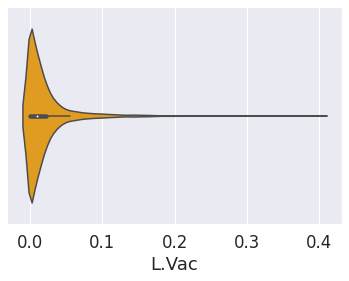

count    8145.000000
mean        0.019174
std         0.031836
min         0.000000
25%         0.000000
50%         0.010000
75%         0.022000
max         0.400000
Name: L.Vac, dtype: float64
Q1: 0.0
Q2: 0.01
Q3: 0.022000000000000002
90%: 0.05


0.08199999999999999

In [27]:
# L.Vac의 데이터 확인
df_LVac = origin_data.iloc[:, -3]

print("■ L.Vac의 분포")
sns.set(font_scale = 1.5)
sns.violinplot(df_LVac, color='orange')
plt.show()
print(df_LVac.describe())

print("Q1:", df_LVac.quantile(0.25))
print("Q2:", df_LVac.quantile(0.50))
print("Q3:", df_LVac.quantile(0.75))
print("90%:", df_LVac.quantile(0.9))
df_LVac.quantile(0.95)

■ L.RD의 분포


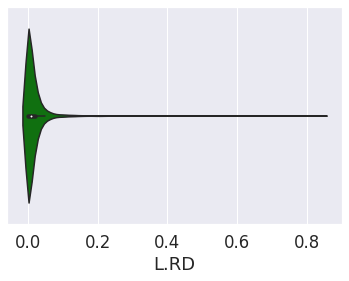

count    8145.000000
mean        0.018049
std         0.045042
min         0.000000
25%         0.000000
50%         0.009000
75%         0.020000
max         0.841000
Name: L.RD, dtype: float64
제1분위수: 0.0
제2분위수: 0.009000000000000001
제3분위수: 0.02
90%에 위치한 값: 0.04
IQR: 0.02
under_bound: [0]
upper_bound: 0.05


In [28]:
# L.RD의 데이터 확인
#plt.boxplot(origin_data.iloc[:, -4], vert=False)

df_LRD = origin_data.iloc[:, -4]

print("■ L.RD의 분포")
sns.set(font_scale = 1.5)
sns.violinplot(df_LRD, color='green')
plt.show()
print(df_LRD.describe())

# 이상치 구하기
# 확인
print("제1분위수:", df_LRD.quantile(0.25))
print("제2분위수:", df_LRD.quantile(0.50))
print("제3분위수:", df_LRD.quantile(0.75))
print("90%에 위치한 값:", df_LRD.quantile(0.9))

Q1 = df_LRD.quantile(0.25)
Q3 = df_LRD.quantile(0.75)
IQR = Q3 - Q1
print("IQR:", IQR)

arr=[Q1-1.5*IQR]
under_bound = [0 if x<0 else x for x in arr]
upper_bound = Q3 + 1.5*IQR
print("under_bound:", under_bound)
print("upper_bound:", upper_bound)

# 불량품/양품 기준
# 'L.RD' 0.05 이상이면 불량품, 미만이면 양품으로 결정함

In [29]:
# 레이블 데이터 확인
origin_data.iloc[:, -4:-2]

,L.RD,L.Vac
dat...date.name.,,
2016-01-01 07,0.025,0.063
2016-01-01 08,0.000,0.022
2016-01-01 09,0.016,0.063
2016-01-01 10,0.000,0.103
2016-01-01 11,0.000,0.000
...,...,...
2016-12-31 19,0.000,0.031
2016-12-31 20,0.010,0.021
2016-12-31 21,0.017,0.009


### 불량품/양품 컬럼 만들기

In [30]:
# 타겟 데이터
df_LRD = origin_data.iloc[:, -4]

# 'L.RD' 의 데이터 중 상위 5% 이상이면 불량품, 미만이면 양품으로 결정함
df_LRD = pd.Series(data = np.where(df_LRD.values > df_LRD.quantile(0.95), 1, 0), 
                   name='L.RD', index=origin_data.index)


print("■ 레이블 개수\n", df_LRD.value_counts())

# 'L.RD' 의 데이터 중 값이 0.05 이상이면 불량품, 미만이면 양품으로 결정함
#df_LRD[df_LRD.values >= 0.05] = 1

■ 레이블 개수
 0    7742
1     403
Name: L.RD, dtype: int64


### 레이블 데이터 합치기 ■ fact_data_LRD
* fact_data_LRD : 레이블을 L.RD로 쓰고 한글컬럼은 제외한 데이터
---
* 데이터 프레임 합치기 : pd.merge와 pd.concat의 차이
* 참고링크 : https://yganalyst.github.io/data_handling/Pd_12/#1-1-pdconcat%EC%9D%98-%EC%98%B5%EC%85%98

In [31]:
# 레이블 없는 데이터에 레이블 시리즈 합치기
fact_data_LRD = pd.concat([fact_data_146, df_LRD], axis=1)
print(fact_data_LRD.shape)

# 만약 여기서 행 개수가 8145개를 넘으면 concat할 때 두 데이터프레임의 인덱스가 달라서 달리 합쳐진 것일 수 있음
# df_origin 불러올 때 인덱스 설정을 동일하게 해주자
# 혹은 fact_data_152['레이블 이름']으로 추가할 수 있음
fact_data_LRD

(8145, 147)


,X1WOS45106_PV,X1WOS45107_PV,X1WOS45109_PV,DCS_Offset_RPM_M11.1WOS45111_PV,DCS_Offset_RPM_M15.1WOS45115_PV,DB.N2.SCREEN.FLOW.LEFT.1FI49011_PV,N2.TO.EA1313A.1FI33503A_PV,ROOF.HEATING.Zone.1.1JIC31101.PV,ROOF.HEATING.Zone.2.1JIC31102.PV,ROOF.HEATING.Zone.3.1JIC31103.PV,ROOF.HEATING.Zone.4.1JIC31104.PV,ATM.FLOW.SECT.9.N2.1FIC33415.PV,Gross.width,Left.edge,LOWER.AB7.Z92.TMP.1TIC41751.PV,UPPER.C2..Z175.TMP.1TIC42307.PV,LIFT.OUT.ROL.MTR.M1.CUR.1WII40101.PV,LIFT.OUT.ROL.MTR.M2.CUR.1WII40102.PV,LEHR.DRV.MTR..M4.1.CUR.1WII40104.PV,LEHR.DRV.MTR..M6.1.CUR.1WII40108.PV,LEHR.DRV.MTR..M7.1.CUR.1WII40110.PV,LEHR.DRV.MTR..M7.2.CUR.1WII40111.PV,LEHR.DRV.MTR..M8.1.CUR.1WII40112.PV,LEHR.DRV.MTR..M8.2.CUR.1WII40113.PV,LEHR.DRV.MTR..M10.2.CUR.1WII40117.PV,LEHR.DRV.MTR..M11.1.CUR.1WII40118.PV,LEHR.DRV.MTR..M12.1.CUR.1WII40120.PV,LEHR.DRV.MTR..M13.1.CUR.1WII40122.PV,LEHR.DRV.MTR..M15.1.CUR.1WII40126.PV,LEHR.DRV.MTR..M16.1.CUR.1WII40128.PV,LEHR.DRV.MTR..M16.2.CUR.1WII40129.PV,LEHR.DRV.MTR..M17.1.CUR.1WII40130.PV,LEHR.DRV.MTR..M18.1.CUR.1WII40132.PV,LEHR.DRV.MTR..M18.2.CUR.1WII40133.PV,LEHR.DRV.MTR..M19.1.CUR.1WII40134.PV,X1WOS45102_PV.1,X1WOS45106_PV.1,DCS_Offset_RPM_M11.1WOS45111_PV.1,DCS_Offset_RPM_M14.1WOS45114_PV.1,TMP.TIN..BAY.1.LEFT.1TI30201.PV,...,LOR.3.L.Axis,LOR.3.L.Hori,bay2_4,bay6_7,l_r_tin_bay10,lc_rc_btm_dn,c_btm_up_dn,l_r_top_n.1,top_1,top_5,D_AB1_L_LR,D_AB2_L_LR,D_AB3_L_LR,D_AB4_U_LR,D_AB5_U_LR,D_AB9_L_LR,D_AB10_U_LR,D_AB11_U_LR,D_AB11_L_LR,D_AB7_L_UL,D_AB8_L_UL,D_C1_U_LR,D_C3_U_LR,D_C4_U_LR,D_C4_L_LR,D_C2_L_UL,D_GLS_AB11_LR,D_GLS_AB7_LR,D_GLS_F_LR,D_GLS_RET_LR,S_AB1_AB2_U_L,S_AB2_AB3_U_L,S_AB4_AB5_U_L,S_AB6_AB7_L_L,S_AB8_AB9_U_L,S_AB9_AB10_U_L,S_AB10_AB11_L_L,S_C1_C2_L_L,S_C3_C4_U_L,L.RD
dat...date.name.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 07,0.126294,0.076956,0.076956,0.147152,-0.227141,-1.514135,-0.218748,0.048973,-3.879360,-2.296037,0.191359,-0.022694,3.027949,2.433864,1.290385,-1.994935,2.803512,2.180684,-0.011076,0.07524,0.01758,-0.02383,5.289937,-0.237516,-4.384738,-0.171091,-0.102056,-0.017896,0.858553,0.008717,0.015664,0.011076,-0.133738,0.011076,1.531614,-0.911596,5.486833,5.271747,6.241618,0.054335,...,0.367484,2.324515,1.386470,3.258018,0.069853,3.293793,0.843899,1.900728,2.707067,1.237408,0.143199,-0.264129,-1.785276,-0.464619,-0.866448,0.133905,1.183474,0.671758,2.048795,-0.414553,2.262545,1.014661,1.935018,0.878525,1.400976,1.264824,-0.331785,-0.336811,0.392527,-1.204339,0.022728,-1.047496,0.040088,-2.477830,1.012915,-0.398517,-1.277785,-0.195736,2.776941,0
2016-01-01 08,0.126294,0.076956,0.076956,0.147152,-0.227141,-1.514135,-0.218748,0.048973,-3.879360,-2.296037,0.191359,-0.022694,3.053693,2.392478,1.189370,-2.011604,2.808048,1.598043,-0.011076,0.07524,0.01758,-0.02383,4.508077,-0.237516,-4.384738,-0.171091,-0.102056,-0.017896,0.858553,0.008717,0.015664,0.011076,-0.133738,0.011076,1.531614,-1.570853,-0.098112,0.015846,-0.080082,0.049592,...,-0.050686,0.857440,1.417538,3.257741,0.102734,3.272101,0.882758,1.920147,2.753289,1.315761,0.164009,-0.229654,-1.734957,-0.426076,-0.885489,0.134373,1.194699,0.569452,2.015731,-0.302930,2.162538,0.978115,1.945713,0.765455,1.269891,1.253210,-0.201602,-0.023749,0.643118,-0.700142,-0.021609,-1.063102,0.030658,-2.508000,1.043599,-0.367705,-1.201661,-0.500742,2.888919,0
2016-01-01 09,0.126294,0.076956,0.076956,0.147152,-0.227141,-1.514135,-0.218748,0.048973,-3.879360,-2.296037,0.191359,-0.022694,3.079437,2.433864,1.041403,-2.104412,1.921064,1.598020,-0.011076,0.07524,0.01758,-0.02383,5.371871,-0.237516,-4.384738,-0.171091,-0.102056,-0.017896,0.858553,0.008717,0.015664,0.011076,2.421443,0.011076,1.531614,-1.570853,-0.098112,0.015846,-0.080082,0.062471,...,-0.410132,-0.717783,1.443347,3.259706,0.119169,3.211826,0.986665,1.717819,2.992712,1.790774,0.172756,-0.199157,-1.786606,-0.391402,-0.872139,0.247968,1.275461,0.585925,2.181967,-0.312238,2.205827,1.060357,1.989144,0.648465,1.058985,1.517443,-0.001965,0.231003,0.893808,-0.499177,-0.0

### 훈련/테스트 데이터 나누기

In [32]:
from sklearn.model_selection import train_test_split

# 피처/레이블 데이터 나누기
X = fact_data_LRD.iloc[:, :-1]
y = fact_data_LRD.iloc[:, -1]

# 훈련/테스트 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6108, 146)
(2037, 146)
(6108,)
(2037,)


---
## 분류 모델
- SVM
- Emsemble Method
    - voting : 여러 알고리즘을 사용하여 비교하고 가장 좋은 모델을 선정
        - hard voting(1, 0으로 리턴)
        - soft voting(확률로 리턴)
    - Bagging : 한 가지 알고리즘을 사용하고 데이터 샘플링을 달리하여 비교
    
    - Boosting :이전 모델 훈련 결과 나온 가중치를 다음 모델 훈련에 적용
    - Stacking

### Xgboost
- 파이썬 외부모듈
- 데이터의 구조를 변경해서 사용해야 함
- XGB Classifier 이용
- 참고 : https://statkclee.github.io/model/model-python-xgboost-hyper.html

#### XGBClassifier 안 쓰고

In [33]:
# XGB 부스트
import xgboost as xgb

# XGboost용 데이터 만들기
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)
print(type(dtrain))

# 하이퍼 파라미터를 변수로 생성함
params = {'max_depth':3, 'eta':0.1, 'objective':'binary:logistic', 'eval_metric':'logloss'}
num_rounds = 400
wlist = [(dtrain, 'train'), (dtest, 'eval')]

# 모델 생성 및 훈련
xgb_model = xgb.train(params = params, dtrain=dtrain, num_boost_round = num_rounds,
                     early_stopping_rounds=100, evals=wlist)
# 400번 수행하도록 설정했지만, 100번 이상 수행해서 더이상 개선된 모델을 찾지 못하면 종료됨
# Stopping. Best iteration:
# [224]	train-logloss:0.485184	eval-logloss:0.606483

<class 'xgboost.core.DMatrix'>
[0]	train-logloss:0.611044	eval-logloss:0.611988
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 100 rounds.
[1]	train-logloss:0.543689	eval-logloss:0.545825
[2]	train-logloss:0.487185	eval-logloss:0.490493
[3]	train-logloss:0.439494	eval-logloss:0.443233
[4]	train-logloss:0.398994	eval-logloss:0.403672
[5]	train-logloss:0.364123	eval-logloss:0.369381
[6]	train-logloss:0.334095	eval-logloss:0.33995
[7]	train-logloss:0.308119	eval-logloss:0.314804
[8]	train-logloss:0.285369	eval-logloss:0.29259
[9]	train-logloss:0.265458	eval-logloss:0.273213
[10]	train-logloss:0.247678	eval-logloss:0.256021
[11]	train-logloss:0.232086	eval-logloss:0.240934
[12]	train-logloss:0.21829	eval-logloss:0.227748
[13]	train-logloss:0.206466	eval-logloss:0.216493
[14]	train-logloss:0.195741	eval-logloss:0.206
[15]	train-logloss:0.186222	eval-logloss:0.196479
[16]	train-logloss:0.177877	eval-lo

In [34]:
# 테스트 데이터를 이용해서 확인
## xgb 분류기는 확률을 리턴함
## 다른 분류기들은 predict를 호출하면 레이블을 리턴
pred_proba = xgb_model.predict(dtest)
print(np.round(pred_proba[:10],3))

[0.023 0.03  0.02  0.018 0.142 0.003 0.001 0.661 0.017 0.023]


In [294]:
# 확률이 50% 이상인 경우 1로 출력, 아닌 경우는 0으로 출력
'''
preds = [ 1 if x > 0.5 else 0 for x in pred_proba]
'''
# 동일한 다른 코드
preds = []
for x in pred_proba:
    if x > 0.5:
        preds.append(1)
    else:
        preds.append(0)

# 확인
print(preds[:10])
print(y_test[:10])

[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
dat...date.name.
2016-12-01 11    0
2016-01-25 08    0
2016-12-08 06    0
2016-10-31 18    0
2016-11-08 21    0
2016-06-11 14    0
2016-05-20 03    0
2016-11-18 19    1
2016-10-06 23    0
2016-10-02 01    0
Name: L.RD, dtype: int64


In [295]:
# XGBoost
# 평가지표출력
# 오차행렬 : 정확도, 정밀도, 재현율, f1 스코어, roc_auc_score(곡선면적)
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
print("테스트 데이터 수", y_test.shape)

print('오차행렬:\n', confusion_matrix(y_test, preds))
print('정확도:', accuracy_score(y_test, preds).round(3))
print('정밀도:', precision_score(y_test, preds).round(3))
print('재현율:', recall_score(y_test, preds).round(3))
print('f1 스코어:', f1_score(y_test, preds).round(3))

# roc_auc_score는 추정확률을 대입해야 함
print('roc_auc_score:', roc_auc_score(y_test, pred_proba).round(3))

테스트 데이터 수 (2037,)
오차행렬:
 [[1920   13]
 [  69   35]]
정확도: 0.96
정밀도: 0.729
재현율: 0.337
f1 스코어: 0.461
roc_auc_score: 0.908


#### XGBClassifier 쓰고

In [35]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.1, max_depth = 3)
xgb_wrapper.fit(X_train, y_train)

# 분류된 클래스 레이블을 리턴
w_pred = xgb_wrapper.predict(X_test)
print("######################예측값######################")
print(w_pred)

# 확률 리턴
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
print("######################예측확률######################")
print(w_pred_proba)

######################예측값######################
[0 0 0 ... 0 0 0]
######################예측확률######################
[0.02268676 0.03055861 0.01988006 ... 0.0260065  0.16618514 0.01271806]


### 평가지표
- 어떤 평가지표를 사용할지 고민해야 함
    - 정확도(accuracy) : TN + TP / 전체
    - 정밀도(precision) : TP / (FP + TP)
        - Pos로 예측한 것 중 실제 Pos였던 것
        - 양성예측도
        - Pos 예측 성능을 더 정밀하게 측정하기 위한 평가지표
        - FP를 낮추는 데 초점
    - 재현율(recall) : TP / (FN + TP)
        - 실제 Pos인 것 중 실제 Pos였던 것
        - 민감도, TPR(True Positive Rate)
        - Pos를 Neg로 판단하면 치명적인 경우 사용
        - FN을 낮추는 데 초점
    - F1 Score
        -  2pr/(p+r)
    - ROC 곡선
        - 이진분류의 예측 성능 측정에 사용
        - FP비율 - TP비율(recall) 곡선
- 이 데이터에서는 극소수의 불량품을 판정하지 못하는 것이 치명적임
    - 따라서 정확도는 적절치 않음
    - 재현율(recall)이 적절한 지표
    - FP가 높고, FN이 낮은지 중점적으로 살펴야 함
    - F1 Score가 적절할 것 같음

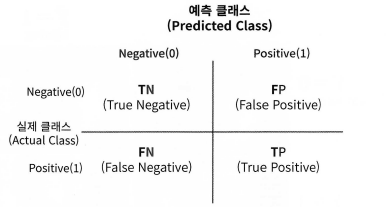

In [36]:
# XGBoost
# 평가지표출력
# 오차행렬 : 정확도, 정밀도, 재현율, f1 스코어, roc_auc_score(곡선면적)
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
print("테스트 데이터 수", y_test.shape)

print('오차행렬:\n', confusion_matrix(y_test, preds))
print('정확도:', accuracy_score(y_test, preds).round(3))
print('정밀도:', precision_score(y_test, preds).round(3))
print('재현율:', recall_score(y_test, preds).round(3))
print('f1 스코어:', f1_score(y_test, preds).round(3))

# roc_auc_score는 추정확률을 대입해야 함
print('roc_auc_score:', roc_auc_score(y_test, pred_proba).round(3))

테스트 데이터 수 (2037,)


NameError: ignored

### 하이퍼 파라미터 조정
- https://statkclee.github.io/model/model-python-xgboost-hyper.html

In [ ]:
#help(XGBClassifier)
'''
params = {'max_depth':3,                 # 가지 제한 - 과적합 방지
          'eta':0.1,                     # 학습률
          'objective':'binary:logistic', # 손실함수 설정. 이진분류니까 binary:logistic
          'eval_metric':'error'          # 검증에 사용되는 함수 - 분류는 error/ㅣlogloss 사용함 # error : 이진분류 에러 비율(경계 0.5)
          }

# 기본옵션
XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, verbosity=1, silent=None, objective='binary:logistic', booster='gbtree', 
              n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, 
              colsample_bynode=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)'''

In [ ]:
from sklearn.model_selection import GridSearchCV

# XGBoost 분류기 생성
xgb_clf = xgb.XGBClassifier()

# 초모수 격자생성
xgb_param_grid = {'max_depth': [5, 6, 7, 8], 
                  'subsample': [0.55, 0.6, 0.65]}

# Create a GridSearchCV object
xgb_grid = GridSearchCV(estimator=xgb_clf,
                       param_grid=xgb_param_grid,
                       scoring='recall',    # 평가지표 recall 설정 됨!
                       n_jobs=-1,
                       cv=5,
                       refit=True, 
                       return_train_score=True)

xgb_grid.fit(X_train, y_train)

In [ ]:
xgb_grid_df = pd.DataFrame(xgb_grid.cv_results_)
xgb_grid_df.loc[:, ['mean_test_score', "params"]]

In [ ]:
## 최고성능
best_score = xgb_grid.best_score_
# 최고성능을 내는 행을 찾아냄
best_row = xgb_grid.best_index_

# 최적의 하이퍼 파라미터: max_depth, subsample
best_max_depth     = xgb_grid.best_params_["max_depth"]
best_max_subsample = xgb_grid.best_params_["subsample"]

print('예측모형성능(recall):  \t', best_score.round(3))
print('인덱스:  \t', best_row)
print('max_depth:  \t', best_max_depth)
print('subsample:  \t', best_max_subsample)
# recall : 0.398 , max_depth=7, subsample=0.6 채택!

#### 재훈련

In [ ]:
# 훈련시 옵션 주기
xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.1, max_depth=7, subsample=0.6)
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='error', 
                eval_set=[(X_test, y_test)], verbose=True)
# 조기 중단이 가능한 xgboost
# early_stopping_rounds=100, eval_metric='logloss'

In [ ]:
# 분류된 클래스 레이블을 리턴
preds = xgb_wrapper.predict(X_test)
print("######################예측값######################")
print(w_pred)

# 확률 리턴
pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
print("######################예측확률######################")
print(w_pred_proba)

In [ ]:
# XGBoost
# 평가지표출력
# 오차행렬 : 정확도, 정밀도, 재현율, f1 스코어, roc_auc_score(곡선면적)
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
print("테스트 데이터 수:", y_test.shape)

print('오차행렬:\n', confusion_matrix(y_test, preds))
print('정확도:', accuracy_score(y_test, preds).round(3))
print('정밀도:', precision_score(y_test, preds).round(3))
print('재현율:', recall_score(y_test, preds).round(3))
print('f1 스코어:', f1_score(y_test, preds).round(3))

# roc_auc_score는 추정확률을 대입해야 함
print('roc_auc_score:', roc_auc_score(y_test, pred_proba).round(3))

# recall : 0.404

### 오버샘플링
- 레이블의 수를 늘리면 모델 성능이 좋아질 것 같음
- 오버샘플링 수행해봄

In [56]:
# 오버샘플링 패키지
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_over, y_train_over = smote.fit_sample(X_train,y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

print('X_test의 shape:', X_test.values.shape)

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (6108, 146) (6108,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (11618, 146) (11618,)
SMOTE 적용 후 레이블 값 분포: 
 1    5809
0    5809
dtype: int64
X_test의 shape: (2037, 146)


In [62]:
# X_train_over를 데이터프레임으로 만들어주자
X_train_over = pd.DataFrame(data=X_train_over, columns = X_test.columns)

#### 재훈련

In [64]:
# 훈련시 옵션 주기
xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.1, max_depth=7, subsample=0.6)
xgb_wrapper.fit(X_train_over, y_train_over, early_stopping_rounds=100, eval_metric='error', eval_set=[(X_test, y_test)], verbose=True)

# ValueError: feature_names mismatch
# X_train_over는 ndarray라 컬럼명이 없고, X_test는 컬럼명이 있어서 오류가 남
# 어느 한 쪽에 맞춰서 오버샘플링 해주자
# 컬럼명 없애는 방법 : df.values로 ndarray 만들어주기
# 컬럼명 만드는 방법 : df로 만들어준다

[0]	validation_0-error:0.120275
Will train until validation_0-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.100147
[2]	validation_0-error:0.108493
[3]	validation_0-error:0.098184
[4]	validation_0-error:0.097202
[5]	validation_0-error:0.087383
[6]	validation_0-error:0.089838
[7]	validation_0-error:0.092293
[8]	validation_0-error:0.088856
[9]	validation_0-error:0.08542
[10]	validation_0-error:0.083947
[11]	validation_0-error:0.078547
[12]	validation_0-error:0.077074
[13]	validation_0-error:0.077565
[14]	validation_0-error:0.073638
[15]	validation_0-error:0.07511
[16]	validation_0-error:0.073147
[17]	validation_0-error:0.071674
[18]	validation_0-error:0.067747
[19]	validation_0-error:0.065783
[20]	validation_0-error:0.063819
[21]	validation_0-error:0.065292
[22]	validation_0-error:0.064801
[23]	validation_0-error:0.061365
[24]	validation_0-error:0.061365
[25]	validation_0-error:0.060383
[26]	validation_0-error:0.061365
[27]	validation_0-error:0.060383
[28]	validation_0-err

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1)

In [65]:
# 분류된 클래스 레이블을 리턴
preds = xgb_wrapper.predict(X_test)
print("######################예측값######################")
print(w_pred)

# 확률 리턴
pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
print("######################예측확률######################")
print(w_pred_proba)

######################예측값######################
[0 0 0 ... 0 0 0]
######################예측확률######################
[0.02268676 0.03055861 0.01988006 ... 0.0260065  0.16618514 0.01271806]


In [66]:
# 평가지표출력
# 오차행렬 : 정확도, 정밀도, 재현율, f1 스코어, roc_auc_score(곡선면적)
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
print("테스트 데이터 수:", y_test.shape)

print('오차행렬:\n', confusion_matrix(y_test, preds))
print('정확도:', accuracy_score(y_test, preds).round(3))
print('정밀도:', precision_score(y_test, preds).round(3))
print('재현율:', recall_score(y_test, preds).round(3))
print('f1 스코어:', f1_score(y_test, preds).round(3))

# roc_auc_score는 추정확률을 대입해야 함
print('roc_auc_score:', roc_auc_score(y_test, pred_proba).round(3))

# 오버샘플링 전 recall : 0.404
# 오버샘플링 후 recall : 0.625

테스트 데이터 수: (2037,)
오차행렬:
 [[1871   62]
 [  39   65]]
정확도: 0.95
정밀도: 0.512
재현율: 0.625
f1 스코어: 0.563
roc_auc_score: 0.916


## 피처 중요도 추출

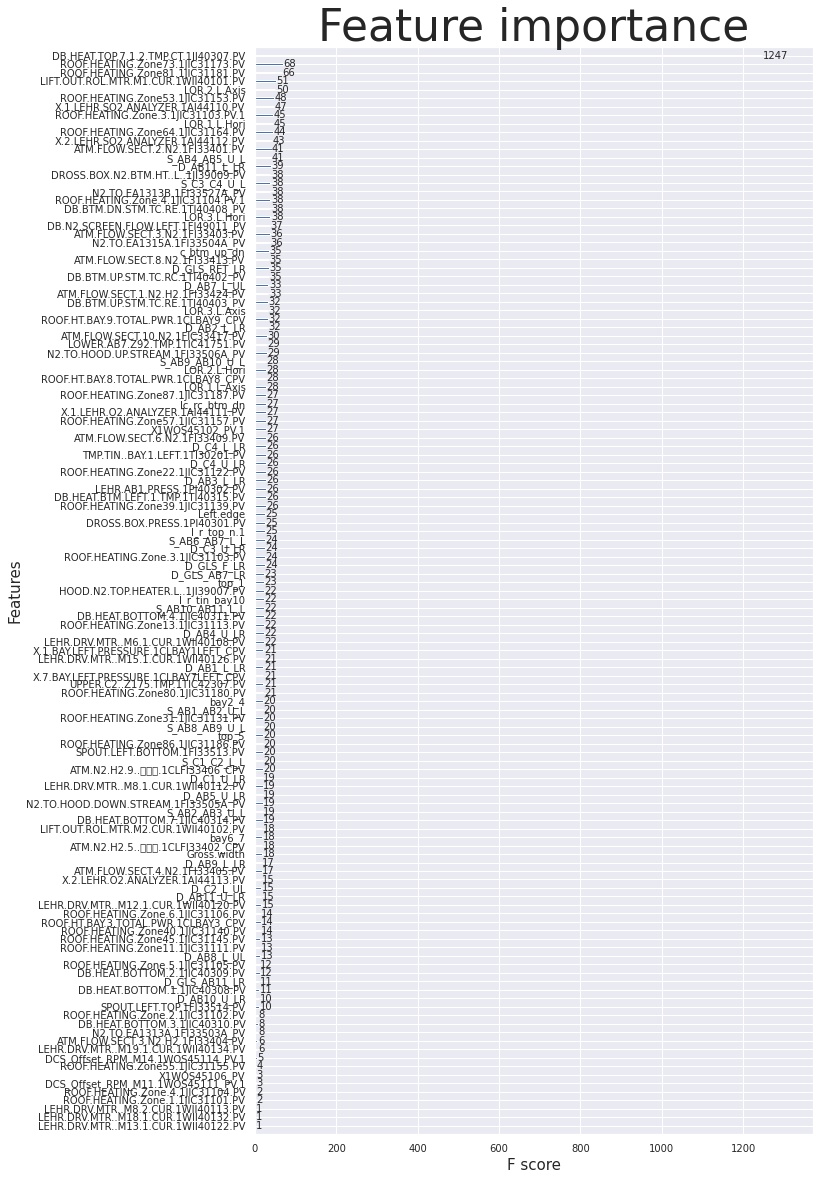

In [71]:
# 특성 중요도 시각화
fig, ax = plt.subplots(figsize=(10, 20))

# xgb는 자체적으로 특성 중요도를 시각화하는 함수(plot_importance)를 제공함
from xgboost import plot_importance
plot_importance(xgb_wrapper, ax)

# 폰트 사이즈
'''plt.rc('font', size=10)          # controls default text sizes  # 중요도
plt.rc('axes', titlesize=44)     # fontsize of the axes title  # 전체타이틀
plt.rc('axes', labelsize=15)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels # x축
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels # y축
plt.rc('legend', fontsize=8)     # legend fontsize
plt.rc('figure', titlesize=44)   # fontsize of the figure title'''

### 모델 개선
	- xgboost 모듈에 to_graphviz()를 이용하면 트리구조 확인 가능함
	- 하이퍼 파라미터 튜닝을 위해 교차검증하는 cv api 제공함

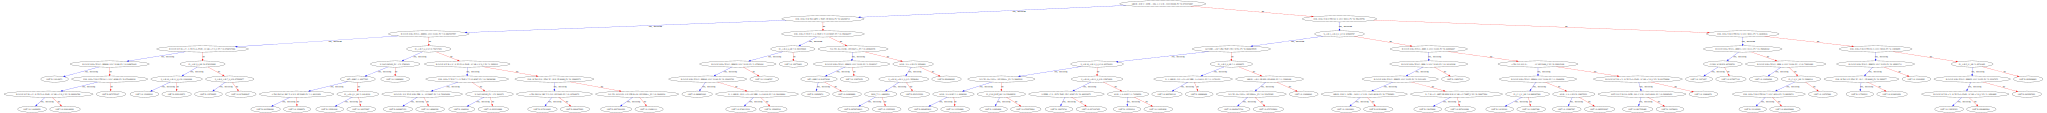

In [70]:
# xgboost 트리구조 확인
xgb.to_graphviz(xgb_wrapper, num_trees=7)

In [ ]:
# 각 데이터별 클래스 예측 확률
pred_proba_calss1 = model_classifier.predict_proba(X_test)[:,0]

# roc_curve
from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(y_test, pred_proba_calss1)
fpr, tpr, threshold

# 시각화
## ROC 곡선
plt.plot(fpr, tpr, label='ROC curve')
## 기준 선
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()